In [24]:
import random
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Subset
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid 
from torch.utils.tensorboard import SummaryWriter


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [26]:
writer = SummaryWriter()

In [27]:
# Load datasets from disk with transforms applied
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for CNNs
    transforms.ToTensor()])

train_data = datasets.INaturalist(root='data/train_mini', version="2021_train_mini", transform=transform, download=False)

train_data_sample_indices = random.sample(range(len(train_data)), 10000)


imgs = torch.stack([train_data[i][0] for i in train_data_sample_indices], dim=3)
sample_mean = imgs.view(3, -1).mean(dim=1)
sample_std = imgs.view(3, -1).std(dim=1)

In [28]:
print(sample_mean, sample_std)

tensor([0.4650, 0.4808, 0.3765]) tensor([0.2345, 0.2253, 0.2434])


In [31]:
train_data_birds = Subset(train_data, bird_indices)

train_data_sample_indices = random.sample(range(len(train_data_birds)), 10000)

imgs = torch.stack([train_data[i][0] for i in train_data_sample_indices], dim=3)
sample_mean_birds = imgs.view(3, -1).mean(dim=1)
sample_std_birds = imgs.view(3, -1).std(dim=1)
print(sample_mean_birds, sample_std_birds)

tensor([0.5146, 0.5185, 0.4124]) tensor([0.2425, 0.2304, 0.2557])


In [32]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224))   ,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),    
    transforms.ToTensor(),
    transforms.Normalize(mean=sample_mean_birds, std=sample_std_birds)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224))   ,
    transforms.ToTensor(), 
    transforms.Normalize(mean=sample_mean_birds, std=sample_std_birds)
])



# Load datasets from disk with transforms applied
train_data = datasets.INaturalist(root='data/train_mini', version="2021_train_mini", transform=train_transform, download=False)
validation_data = datasets.INaturalist(root='data/validation', version="2021_valid", transform=val_transform, download=False)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_data, batch_size=128, shuffle=True, num_workers=4)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(validation_data)}")

Training samples: 500000
Validation samples: 100000


In [33]:
cat_list = [int(cat[1:5]) for cat in train_data.all_categories if "Animalia_Chordata_Aves" in cat]
# get corresponding labels

In [34]:
# bird_indices = []
# for i, (_, label) in enumerate(train_data):
#     print(i, label)
#     if label > 4596:
#         break
#     if label >= 3111 and label <= 4596:
#         bird_indices.append(i)

In [35]:
# with open('bird_indices.txt', 'w') as f:
#     for line in bird_indices:
#         f.write(f"{line}\n")

In [36]:
bird_indices = []
with open('bird_indices.txt', 'r') as f:
    for line in f:
        bird_indices.append(int(line[0:-1]))

In [37]:
# bird_val_indices = []
# for i, (_, label) in enumerate(validation_data):
#     if label > 4596:
#         break
#     if label >= 3111 and label <= 4596:
#         bird_val_indices.append(i)

In [38]:
# with open('bird_val_indices.txt', 'w') as f:
#     for line in bird_val_indices:
#         f.write(f"{line}\n")

In [39]:
bird_val_indices = []
with open('bird_val_indices.txt', 'r') as f:
    for line in f:
        bird_val_indices.append(int(line[0:-1]))

In [40]:
# Find all indices where the target (label) corresponds to birds
# Create a subset dataset containing only birds
train_data_birds = Subset(train_data, bird_indices)

# Create a DataLoader for the filtered dataset
train_loader_birds = DataLoader(train_data_birds, batch_size=32, shuffle=True, num_workers=4)

val_data_birds = Subset(validation_data, bird_val_indices)
val_loader_birds = DataLoader(val_data_birds, batch_size=32, shuffle=True, num_workers=4)

print(f"Filtered train dataset contains {len(train_data_birds)} bird images.")
print(f"Filtered val dataset contains {len(val_data_birds)} bird images.")

Filtered train dataset contains 74300 bird images.
Filtered val dataset contains 14860 bird images.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


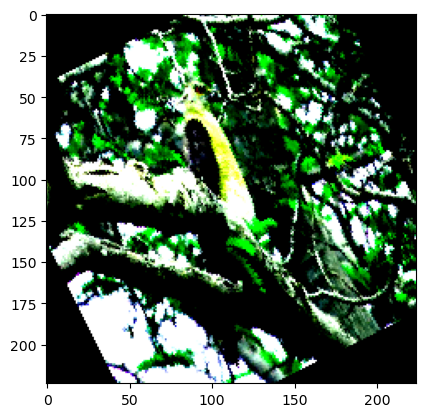

In [41]:
plt.imshow(train_data_birds[1][0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


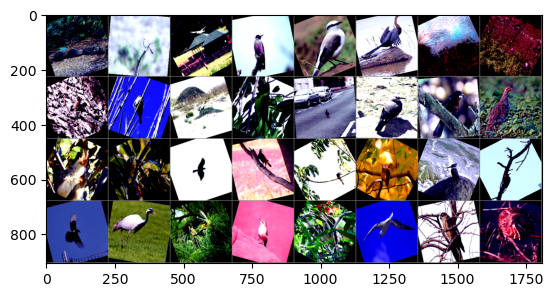

In [42]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader_birds)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))

In [43]:
n_classes = len(cat_list)
n_classes

1486

In [44]:
def remap_labels(labels):
    return (labels - 3111).long()  # Convert labels to tensor and ensure they are Long type


def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()  # Set to training mode

    train_n = len(train_loader)
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            labels = remap_labels(labels).to(device)
            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        # Print epoch stats
        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f} - Accuracy: {100 * correct / total:.2f}%")


In [45]:
torch.cuda.empty_cache()

In [46]:
# Define a Simple CNN Model
class SimpleCNN_2(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN_2, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm4 = nn.BatchNorm2d(128)


        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 14 * 14, 2000)  # 64 channels, 28x28 image size after pooling
        self.fc2 = nn.Linear(2000, num_classes)   # Output layer
        
        # Dropout to prevent overfitting
        self.conv_dropout = nn.Dropout2d(0.3)
        self.conv2_dropout = nn.Dropout2d(0.3)
        self.conv3_dropout = nn.Dropout2d(0.3)
        self.conv4_dropout = nn.Dropout2d(0.3)
    
    def forward(self, x):
        x = self.pool(self.batchnorm1(F.relu(self.conv1(x))))  # Conv1 -> ReLU -> MaxPool
        x = self.conv_dropout(x)
        x = self.pool(self.batchnorm2(F.relu(self.conv2(x))))  # Conv2 -> ReLU -> MaxPool
        x = self.conv2_dropout(x)
        x = self.pool(self.batchnorm3(F.relu(self.conv3(x))))  # Conv3 -> ReLU -> MaxPool
        x = self.conv3_dropout(x)
        x = self.pool(self.batchnorm4(F.relu(self.conv4(x))))  # Conv4 -> ReLU -> MaxPool
        x = self.conv4_dropout(x)
        x = x.view(x.shape[0], -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer
        return x

In [ ]:
def log_metrics_tensor_board(data_type, accuracy, top_5_accuracy, loss, epoch ):
    writer.add_scalar(f"Loss -  {data_type}", loss, epoch)
    writer.add_scalar(f"Accuracy -  {data_type}", 100 * accuracy, epoch)
    writer.add_scalar(f"Top 5 Accuracy - {data_type}", 100 * top_5_accuracy, epoch)
    return


def run_epoch(model, loader, criterion, optimizer=None, epoch=0, mode="train"):
    is_train = mode == "train"
    model.train() if is_train else model.eval()

    running_loss = 0.0
    correct = 0
    top_5_correct = 0
    total = 0

    with torch.set_grad_enabled(is_train):  # Only compute gradients during training
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            labels = remap_labels(labels).to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            # count total correct predicitions in batch
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            # count total matches of label in top 5 class predictions 
            _, top_5_predicted = outputs.topk(5, dim=1)
            top_5_correct += torch.isin(labels, top_5_predicted).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    top_5_accuracy = top_5_correct / total
    log_metrics_tensor_board(mode, accuracy, top_5_accuracy, avg_loss, epoch)

    print(f"{mode.capitalize()} Accuracy: {100 * accuracy:.2f}%")
    print(f"Top 5 {mode.capitalize()} Accuracy: {100 * top_5_accuracy:.2f}%")
    print(f"Epoch {epoch+1} - {mode.capitalize()} Loss: {avg_loss:.4f}")


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        run_epoch(model, train_loader, criterion, optimizer, epoch, mode="train")
        run_epoch(model, val_loader, criterion, None, epoch, mode="validation")


In [ ]:
# save model
# store eval scores for plotting 
# stopping criteria? i.e when does val score not descrease for n consecutive epochs

simple_cnn_2 = SimpleCNN_2(num_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(simple_cnn_2.parameters(), lr=0.0001)


# Train the model
train_model(simple_cnn_2, train_loader_birds, val_loader_birds, criterion, optimizer, epochs=100)

Epoch 1/100 - Loss: 7.2701 - Accuracy: 0.10%
Validation Accuracy: 0.12%
Top 5 validation Accuracy: 5.65%
Epoch 2/100 - Loss: 7.0835 - Accuracy: 0.22%
Validation Accuracy: 0.37%
Top 5 validation Accuracy: 6.28%
Epoch 3/100 - Loss: 6.8876 - Accuracy: 0.33%
Validation Accuracy: 0.46%
Top 5 validation Accuracy: 8.26%
Epoch 4/100 - Loss: 6.7461 - Accuracy: 0.50%
Validation Accuracy: 0.53%
Top 5 validation Accuracy: 9.49%
Epoch 5/100 - Loss: 6.6449 - Accuracy: 0.67%
Validation Accuracy: 0.66%
Top 5 validation Accuracy: 10.93%
Epoch 6/100 - Loss: 6.5551 - Accuracy: 0.90%
Validation Accuracy: 0.92%
Top 5 validation Accuracy: 11.86%


In [ ]:
bird_classes = [cat for cat in train_data.all_categories if "Animalia_Chordata_Aves" in cat]

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in bird_classes}
total_pred = {classname: 0 for classname in bird_classes}

# again no gradients needed
with torch.no_grad():
    for data in val_loader_birds:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels = remap_labels(labels).to(device)
        outputs = simple_cnn_2(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[bird_classes[label]] += 1
            total_pred[bird_classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')